In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import random
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

from Libraries.dataloader import DataLoader as DL
# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#  Inicjalizowane danych


In [2]:
device = 'cuda'

# Załadowanie danych
Ładujemy dane do zmiennych a następnie odpowiednio przekształcamy

In [3]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

# Load Data

In [4]:
# DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
# dl = DL()
# A_RGBD_input,A_axis_out = dl.load(DATASET_ROOTDIR, 'files_ArUco/data_ArUco.csv', 'R')

# DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
# B_RGBD_input,B_axis_out = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'R')

# RGBD_input = torch.cat((A_RGBD_input, B_RGBD_input),axis=0)
# axis_out = torch.cat((A_axis_out, B_axis_out),axis=0)

# X_train, X_validation, y_train, y_validation = train_test_split(RGBD_input, axis_out, test_size=0.2)
# print(X_train.shape)

In [5]:
DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()

X_train, y_train = dl.load(DATASET_ROOTDIR, 'files/data_TRA.csv', 'R')
X_validation, y_validation = dl.load(DATASET_ROOTDIR, 'files/data_VAL.csv', 'R')
print(X_train.shape)

torch.Size([132, 3, 256, 320])


# RGB + D 
Na wejście do modelu zostanie podany tensor zawieający kombinację RGB + D 

In [6]:
X_train_aug = X_train.clone()

for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
y_train = torch.cat((y_train, y_train),axis=0)
X_train = torch.cat((X_train, X_train_aug),axis=0)

In [7]:
AoRD_trainDataset = TensorDataset(X_train, y_train)
AoRD_validationDataset = TensorDataset(X_validation, y_validation)

In [8]:
train_loader = DataLoader(AoRD_trainDataset, batch_size=10, shuffle=False)
validation_loader = DataLoader(AoRD_validationDataset, batch_size=10, shuffle=False)

# Wyciąganie pojedyńczego elementu z batcha
Można zrobić to na kilka sposobów, ale ten jest najszybszy

In [9]:
# for b, (X_train, y_train) in enumerate(train_loader):
#     pass

# Stworzenie modelu
Nazwałem model AoRNet od angielsiego **A**xis **o**f **R**rotation oraz od nazwy modelu matki Res**Net**`u 

In [10]:
class AoRNet(nn.Module):
    def __init__(self,pretrained=False ,input_channels=3, output_size=6):
        super().__init__()
        self.resnet50 = models.resnet50(pretrained=pretrained)
        self.resnet50.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet50.fc = nn.Linear(in_features=2048, out_features=output_size, bias=True)
    
    def forward(self, X):
        return self.resnet50(X)

In [11]:
Model = AoRNet().to(device)

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=5)

In [13]:
epochs = 150

train_losses = []
validation_losses = []

for i in range(epochs):
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
                
        # Apply the model
        y_pred = Model(X_train)
        loss = criterion(y_pred, y_train)
#         torch.cuda.empty_cache()
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1 == 0:
            print(f'epoch: {i+1:2}  batch: {b}  loss: {loss.item():10.8f}')
    
    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
    
    # Run the validationing batches
    with torch.no_grad():
        for b, (X_validation, y_validation) in enumerate(validation_loader):
            # Apply the model
            
            X_validation = X_validation.to(device)
            y_validation = y_validation.to(device)
            
            y_val = Model(X_validation)
    loss = criterion(y_val, y_validation)
    validation_losses.append(loss.cpu().detach().numpy())
#     validation_correct.append(tst_corr)

epoch:  1  batch: 1  loss: 2.67334485
epoch:  1  batch: 2  loss: 1.49672937
epoch:  1  batch: 3  loss: 0.79887384
epoch:  1  batch: 4  loss: 0.66433692
epoch:  1  batch: 5  loss: 1.05269563
epoch:  1  batch: 6  loss: 0.32144460
epoch:  1  batch: 7  loss: 0.03722353
epoch:  1  batch: 8  loss: 0.08537060
epoch:  1  batch: 9  loss: 0.43142235
epoch:  1  batch: 10  loss: 0.10107740
epoch:  1  batch: 11  loss: 0.07470337
epoch:  1  batch: 12  loss: 0.12556303
epoch:  1  batch: 13  loss: 0.08139463
epoch:  1  batch: 14  loss: 0.58629119
epoch:  1  batch: 15  loss: 0.46535707
epoch:  1  batch: 16  loss: 0.45639259
epoch:  1  batch: 17  loss: 0.38224304
epoch:  1  batch: 18  loss: 0.47412768
epoch:  1  batch: 19  loss: 0.18754523
epoch:  1  batch: 20  loss: 0.26012224
epoch:  1  batch: 21  loss: 0.25785583
epoch:  1  batch: 22  loss: 0.28109348
epoch:  1  batch: 23  loss: 0.17886798
epoch:  1  batch: 24  loss: 0.37082294
epoch:  1  batch: 25  loss: 0.20787929
epoch:  1  batch: 26  loss: 0.0657

epoch:  8  batch: 25  loss: 0.09421252
epoch:  8  batch: 26  loss: 0.08314362
epoch:  8  batch: 27  loss: 0.33842850
epoch:  9  batch: 1  loss: 0.04900849
epoch:  9  batch: 2  loss: 0.04998749
epoch:  9  batch: 3  loss: 0.29420343
epoch:  9  batch: 4  loss: 0.20019595
epoch:  9  batch: 5  loss: 0.04463013
epoch:  9  batch: 6  loss: 0.03232966
epoch:  9  batch: 7  loss: 0.01104950
epoch:  9  batch: 8  loss: 0.01567268
epoch:  9  batch: 9  loss: 0.05145514
epoch:  9  batch: 10  loss: 0.04776374
epoch:  9  batch: 11  loss: 0.04033171
epoch:  9  batch: 12  loss: 0.13743702
epoch:  9  batch: 13  loss: 0.16626073
epoch:  9  batch: 14  loss: 0.15050246
epoch:  9  batch: 15  loss: 0.07204069
epoch:  9  batch: 16  loss: 0.20960627
epoch:  9  batch: 17  loss: 0.13196668
epoch:  9  batch: 18  loss: 0.02609194
epoch:  9  batch: 19  loss: 0.04569640
epoch:  9  batch: 20  loss: 0.02847967
epoch:  9  batch: 21  loss: 0.01946113
epoch:  9  batch: 22  loss: 0.03588555
epoch:  9  batch: 23  loss: 0.0381

epoch: 16  batch: 21  loss: 0.01204112
epoch: 16  batch: 22  loss: 0.03581125
epoch: 16  batch: 23  loss: 0.03135164
epoch: 16  batch: 24  loss: 0.02877958
epoch: 16  batch: 25  loss: 0.07682656
epoch: 16  batch: 26  loss: 0.07112002
epoch: 16  batch: 27  loss: 0.27951860
epoch: 17  batch: 1  loss: 0.03630991
epoch: 17  batch: 2  loss: 0.05043493
epoch: 17  batch: 3  loss: 0.06301288
epoch: 17  batch: 4  loss: 0.04403741
epoch: 17  batch: 5  loss: 0.02275657
epoch: 17  batch: 6  loss: 0.01882281
epoch: 17  batch: 7  loss: 0.00828795
epoch: 17  batch: 8  loss: 0.01340425
epoch: 17  batch: 9  loss: 0.04702621
epoch: 17  batch: 10  loss: 0.03408001
epoch: 17  batch: 11  loss: 0.02626810
epoch: 17  batch: 12  loss: 0.04891604
epoch: 17  batch: 13  loss: 0.09484163
epoch: 17  batch: 14  loss: 0.06755279
epoch: 17  batch: 15  loss: 0.05644520
epoch: 17  batch: 16  loss: 0.19698891
epoch: 17  batch: 17  loss: 0.10397212
epoch: 17  batch: 18  loss: 0.02300321
epoch: 17  batch: 19  loss: 0.0355

epoch: 24  batch: 17  loss: 0.10196211
epoch: 24  batch: 18  loss: 0.02268153
epoch: 24  batch: 19  loss: 0.03464363
epoch: 24  batch: 20  loss: 0.02626361
epoch: 24  batch: 21  loss: 0.01157624
epoch: 24  batch: 22  loss: 0.03601935
epoch: 24  batch: 23  loss: 0.03119297
epoch: 24  batch: 24  loss: 0.02787640
epoch: 24  batch: 25  loss: 0.07137187
epoch: 24  batch: 26  loss: 0.06888489
epoch: 24  batch: 27  loss: 0.26905358
epoch: 25  batch: 1  loss: 0.03542812
epoch: 25  batch: 2  loss: 0.04622535
epoch: 25  batch: 3  loss: 0.05856873
epoch: 25  batch: 4  loss: 0.04038659
epoch: 25  batch: 5  loss: 0.02215171
epoch: 25  batch: 6  loss: 0.01740923
epoch: 25  batch: 7  loss: 0.00819511
epoch: 25  batch: 8  loss: 0.01321087
epoch: 25  batch: 9  loss: 0.04481784
epoch: 25  batch: 10  loss: 0.03389077
epoch: 25  batch: 11  loss: 0.02562828
epoch: 25  batch: 12  loss: 0.04740039
epoch: 25  batch: 13  loss: 0.09182558
epoch: 25  batch: 14  loss: 0.06590918
epoch: 25  batch: 15  loss: 0.0551

epoch: 32  batch: 13  loss: 0.09173065
epoch: 32  batch: 14  loss: 0.06584077
epoch: 32  batch: 15  loss: 0.05499228
epoch: 32  batch: 16  loss: 0.19371669
epoch: 32  batch: 17  loss: 0.10155843
epoch: 32  batch: 18  loss: 0.02263749
epoch: 32  batch: 19  loss: 0.03449712
epoch: 32  batch: 20  loss: 0.02618532
epoch: 32  batch: 21  loss: 0.01152835
epoch: 32  batch: 22  loss: 0.03602352
epoch: 32  batch: 23  loss: 0.03115886
epoch: 32  batch: 24  loss: 0.02781379
epoch: 32  batch: 25  loss: 0.07109377
epoch: 32  batch: 26  loss: 0.06875569
epoch: 32  batch: 27  loss: 0.26843137
epoch: 33  batch: 1  loss: 0.03538425
epoch: 33  batch: 2  loss: 0.04602551
epoch: 33  batch: 3  loss: 0.05832714
epoch: 33  batch: 4  loss: 0.04017936
epoch: 33  batch: 5  loss: 0.02212520
epoch: 33  batch: 6  loss: 0.01738371
epoch: 33  batch: 7  loss: 0.00818580
epoch: 33  batch: 8  loss: 0.01317853
epoch: 33  batch: 9  loss: 0.04473267
epoch: 33  batch: 10  loss: 0.03386299
epoch: 33  batch: 11  loss: 0.0256

epoch: 40  batch: 9  loss: 0.04472277
epoch: 40  batch: 10  loss: 0.03386283
epoch: 40  batch: 11  loss: 0.02560245
epoch: 40  batch: 12  loss: 0.04738868
epoch: 40  batch: 13  loss: 0.09171617
epoch: 40  batch: 14  loss: 0.06583612
epoch: 40  batch: 15  loss: 0.05500172
epoch: 40  batch: 16  loss: 0.19372694
epoch: 40  batch: 17  loss: 0.10155879
epoch: 40  batch: 18  loss: 0.02263913
epoch: 40  batch: 19  loss: 0.03449538
epoch: 40  batch: 20  loss: 0.02618826
epoch: 40  batch: 21  loss: 0.01152883
epoch: 40  batch: 22  loss: 0.03602520
epoch: 40  batch: 23  loss: 0.03115971
epoch: 40  batch: 24  loss: 0.02781140
epoch: 40  batch: 25  loss: 0.07108657
epoch: 40  batch: 26  loss: 0.06874967
epoch: 40  batch: 27  loss: 0.26839501
epoch: 41  batch: 1  loss: 0.03538179
epoch: 41  batch: 2  loss: 0.04601488
epoch: 41  batch: 3  loss: 0.05831762
epoch: 41  batch: 4  loss: 0.04016907
epoch: 41  batch: 5  loss: 0.02212619
epoch: 41  batch: 6  loss: 0.01737867
epoch: 41  batch: 7  loss: 0.008

epoch: 48  batch: 5  loss: 0.02212626
epoch: 48  batch: 6  loss: 0.01738444
epoch: 48  batch: 7  loss: 0.00818543
epoch: 48  batch: 8  loss: 0.01317971
epoch: 48  batch: 9  loss: 0.04471563
epoch: 48  batch: 10  loss: 0.03386257
epoch: 48  batch: 11  loss: 0.02560396
epoch: 48  batch: 12  loss: 0.04738300
epoch: 48  batch: 13  loss: 0.09171046
epoch: 48  batch: 14  loss: 0.06582989
epoch: 48  batch: 15  loss: 0.05499379
epoch: 48  batch: 16  loss: 0.19372566
epoch: 48  batch: 17  loss: 0.10157001
epoch: 48  batch: 18  loss: 0.02264125
epoch: 48  batch: 19  loss: 0.03449076
epoch: 48  batch: 20  loss: 0.02619074
epoch: 48  batch: 21  loss: 0.01152621
epoch: 48  batch: 22  loss: 0.03602611
epoch: 48  batch: 23  loss: 0.03115964
epoch: 48  batch: 24  loss: 0.02780757
epoch: 48  batch: 25  loss: 0.07106748
epoch: 48  batch: 26  loss: 0.06874579
epoch: 48  batch: 27  loss: 0.26838660
epoch: 49  batch: 1  loss: 0.03538047
epoch: 49  batch: 2  loss: 0.04600009
epoch: 49  batch: 3  loss: 0.058

epoch: 56  batch: 1  loss: 0.03537787
epoch: 56  batch: 2  loss: 0.04599557
epoch: 56  batch: 3  loss: 0.05831428
epoch: 56  batch: 4  loss: 0.04017284
epoch: 56  batch: 5  loss: 0.02212371
epoch: 56  batch: 6  loss: 0.01737968
epoch: 56  batch: 7  loss: 0.00818578
epoch: 56  batch: 8  loss: 0.01318067
epoch: 56  batch: 9  loss: 0.04470641
epoch: 56  batch: 10  loss: 0.03386130
epoch: 56  batch: 11  loss: 0.02560093
epoch: 56  batch: 12  loss: 0.04737742
epoch: 56  batch: 13  loss: 0.09170657
epoch: 56  batch: 14  loss: 0.06582697
epoch: 56  batch: 15  loss: 0.05499046
epoch: 56  batch: 16  loss: 0.19373567
epoch: 56  batch: 17  loss: 0.10157233
epoch: 56  batch: 18  loss: 0.02264271
epoch: 56  batch: 19  loss: 0.03450464
epoch: 56  batch: 20  loss: 0.02619458
epoch: 56  batch: 21  loss: 0.01152778
epoch: 56  batch: 22  loss: 0.03602696
epoch: 56  batch: 23  loss: 0.03115910
epoch: 56  batch: 24  loss: 0.02780559
epoch: 56  batch: 25  loss: 0.07106371
epoch: 56  batch: 26  loss: 0.0687

epoch: 63  batch: 25  loss: 0.07104942
epoch: 63  batch: 26  loss: 0.06873705
epoch: 63  batch: 27  loss: 0.26831111
epoch: 64  batch: 1  loss: 0.03537462
epoch: 64  batch: 2  loss: 0.04597747
epoch: 64  batch: 3  loss: 0.05830359
epoch: 64  batch: 4  loss: 0.04017159
epoch: 64  batch: 5  loss: 0.02212250
epoch: 64  batch: 6  loss: 0.01737031
epoch: 64  batch: 7  loss: 0.00818575
epoch: 64  batch: 8  loss: 0.01317713
epoch: 64  batch: 9  loss: 0.04469594
epoch: 64  batch: 10  loss: 0.03385960
epoch: 64  batch: 11  loss: 0.02559843
epoch: 64  batch: 12  loss: 0.04736628
epoch: 64  batch: 13  loss: 0.09168549
epoch: 64  batch: 14  loss: 0.06581793
epoch: 64  batch: 15  loss: 0.05499734
epoch: 64  batch: 16  loss: 0.19375460
epoch: 64  batch: 17  loss: 0.10158408
epoch: 64  batch: 18  loss: 0.02264852
epoch: 64  batch: 19  loss: 0.03450431
epoch: 64  batch: 20  loss: 0.02620182
epoch: 64  batch: 21  loss: 0.01152673
epoch: 64  batch: 22  loss: 0.03602776
epoch: 64  batch: 23  loss: 0.0311

epoch: 71  batch: 21  loss: 0.01152568
epoch: 71  batch: 22  loss: 0.03603030
epoch: 71  batch: 23  loss: 0.03115987
epoch: 71  batch: 24  loss: 0.02779980
epoch: 71  batch: 25  loss: 0.07103440
epoch: 71  batch: 26  loss: 0.06873107
epoch: 71  batch: 27  loss: 0.26827115
epoch: 72  batch: 1  loss: 0.03537141
epoch: 72  batch: 2  loss: 0.04596552
epoch: 72  batch: 3  loss: 0.05829575
epoch: 72  batch: 4  loss: 0.04015396
epoch: 72  batch: 5  loss: 0.02211893
epoch: 72  batch: 6  loss: 0.01736393
epoch: 72  batch: 7  loss: 0.00818526
epoch: 72  batch: 8  loss: 0.01317951
epoch: 72  batch: 9  loss: 0.04468591
epoch: 72  batch: 10  loss: 0.03385900
epoch: 72  batch: 11  loss: 0.02559169
epoch: 72  batch: 12  loss: 0.04735884
epoch: 72  batch: 13  loss: 0.09167122
epoch: 72  batch: 14  loss: 0.06581038
epoch: 72  batch: 15  loss: 0.05499000
epoch: 72  batch: 16  loss: 0.19374938
epoch: 72  batch: 17  loss: 0.10158708
epoch: 72  batch: 18  loss: 0.02264799
epoch: 72  batch: 19  loss: 0.0345

epoch: 79  batch: 17  loss: 0.10159718
epoch: 79  batch: 18  loss: 0.02265134
epoch: 79  batch: 19  loss: 0.03451549
epoch: 79  batch: 20  loss: 0.02621427
epoch: 79  batch: 21  loss: 0.01152707
epoch: 79  batch: 22  loss: 0.03603060
epoch: 79  batch: 23  loss: 0.03116042
epoch: 79  batch: 24  loss: 0.02779700
epoch: 79  batch: 25  loss: 0.07100984
epoch: 79  batch: 26  loss: 0.06872473
epoch: 79  batch: 27  loss: 0.26826438
epoch: 80  batch: 1  loss: 0.03536822
epoch: 80  batch: 2  loss: 0.04594607
epoch: 80  batch: 3  loss: 0.05828891
epoch: 80  batch: 4  loss: 0.04015381
epoch: 80  batch: 5  loss: 0.02211798
epoch: 80  batch: 6  loss: 0.01735196
epoch: 80  batch: 7  loss: 0.00818484
epoch: 80  batch: 8  loss: 0.01318175
epoch: 80  batch: 9  loss: 0.04467854
epoch: 80  batch: 10  loss: 0.03386037
epoch: 80  batch: 11  loss: 0.02558874
epoch: 80  batch: 12  loss: 0.04734708
epoch: 80  batch: 13  loss: 0.09165040
epoch: 80  batch: 14  loss: 0.06580080
epoch: 80  batch: 15  loss: 0.0549

epoch: 87  batch: 13  loss: 0.09163628
epoch: 87  batch: 14  loss: 0.06579439
epoch: 87  batch: 15  loss: 0.05498549
epoch: 87  batch: 16  loss: 0.19377846
epoch: 87  batch: 17  loss: 0.10160088
epoch: 87  batch: 18  loss: 0.02265517
epoch: 87  batch: 19  loss: 0.03451774
epoch: 87  batch: 20  loss: 0.02621666
epoch: 87  batch: 21  loss: 0.01152359
epoch: 87  batch: 22  loss: 0.03603251
epoch: 87  batch: 23  loss: 0.03116038
epoch: 87  batch: 24  loss: 0.02779275
epoch: 87  batch: 25  loss: 0.07098829
epoch: 87  batch: 26  loss: 0.06871711
epoch: 87  batch: 27  loss: 0.26820976
epoch: 88  batch: 1  loss: 0.03536562
epoch: 88  batch: 2  loss: 0.04592670
epoch: 88  batch: 3  loss: 0.05827642
epoch: 88  batch: 4  loss: 0.04014381
epoch: 88  batch: 5  loss: 0.02211579
epoch: 88  batch: 6  loss: 0.01734709
epoch: 88  batch: 7  loss: 0.00818560
epoch: 88  batch: 8  loss: 0.01317926
epoch: 88  batch: 9  loss: 0.04467056
epoch: 88  batch: 10  loss: 0.03385743
epoch: 88  batch: 11  loss: 0.0255

epoch: 95  batch: 9  loss: 0.04466463
epoch: 95  batch: 10  loss: 0.03385841
epoch: 95  batch: 11  loss: 0.02558160
epoch: 95  batch: 12  loss: 0.04732798
epoch: 95  batch: 13  loss: 0.09162661
epoch: 95  batch: 14  loss: 0.06578794
epoch: 95  batch: 15  loss: 0.05498886
epoch: 95  batch: 16  loss: 0.19377163
epoch: 95  batch: 17  loss: 0.10161855
epoch: 95  batch: 18  loss: 0.02265530
epoch: 95  batch: 19  loss: 0.03452441
epoch: 95  batch: 20  loss: 0.02622456
epoch: 95  batch: 21  loss: 0.01152328
epoch: 95  batch: 22  loss: 0.03603391
epoch: 95  batch: 23  loss: 0.03116102
epoch: 95  batch: 24  loss: 0.02778875
epoch: 95  batch: 25  loss: 0.07097742
epoch: 95  batch: 26  loss: 0.06871175
epoch: 95  batch: 27  loss: 0.26816905
epoch: 96  batch: 1  loss: 0.03536134
epoch: 96  batch: 2  loss: 0.04591735
epoch: 96  batch: 3  loss: 0.05826842
epoch: 96  batch: 4  loss: 0.04014084
epoch: 96  batch: 5  loss: 0.02211376
epoch: 96  batch: 6  loss: 0.01733420
epoch: 96  batch: 7  loss: 0.008

epoch: 103  batch: 3  loss: 0.05824773
epoch: 103  batch: 4  loss: 0.04013505
epoch: 103  batch: 5  loss: 0.02210902
epoch: 103  batch: 6  loss: 0.01732232
epoch: 103  batch: 7  loss: 0.00818444
epoch: 103  batch: 8  loss: 0.01317888
epoch: 103  batch: 9  loss: 0.04465107
epoch: 103  batch: 10  loss: 0.03385816
epoch: 103  batch: 11  loss: 0.02557584
epoch: 103  batch: 12  loss: 0.04731666
epoch: 103  batch: 13  loss: 0.09160379
epoch: 103  batch: 14  loss: 0.06577762
epoch: 103  batch: 15  loss: 0.05498175
epoch: 103  batch: 16  loss: 0.19378059
epoch: 103  batch: 17  loss: 0.10162594
epoch: 103  batch: 18  loss: 0.02265897
epoch: 103  batch: 19  loss: 0.03452100
epoch: 103  batch: 20  loss: 0.02623679
epoch: 103  batch: 21  loss: 0.01152013
epoch: 103  batch: 22  loss: 0.03603364
epoch: 103  batch: 23  loss: 0.03116204
epoch: 103  batch: 24  loss: 0.02778555
epoch: 103  batch: 25  loss: 0.07095787
epoch: 103  batch: 26  loss: 0.06869731
epoch: 103  batch: 27  loss: 0.26812527
epoch: 

epoch: 110  batch: 22  loss: 0.03603509
epoch: 110  batch: 23  loss: 0.03116172
epoch: 110  batch: 24  loss: 0.02778164
epoch: 110  batch: 25  loss: 0.07094279
epoch: 110  batch: 26  loss: 0.06868742
epoch: 110  batch: 27  loss: 0.26810727
epoch: 111  batch: 1  loss: 0.03535147
epoch: 111  batch: 2  loss: 0.04588215
epoch: 111  batch: 3  loss: 0.05822575
epoch: 111  batch: 4  loss: 0.04013980
epoch: 111  batch: 5  loss: 0.02210625
epoch: 111  batch: 6  loss: 0.01731792
epoch: 111  batch: 7  loss: 0.00818484
epoch: 111  batch: 8  loss: 0.01317598
epoch: 111  batch: 9  loss: 0.04463585
epoch: 111  batch: 10  loss: 0.03385361
epoch: 111  batch: 11  loss: 0.02557011
epoch: 111  batch: 12  loss: 0.04730213
epoch: 111  batch: 13  loss: 0.09159173
epoch: 111  batch: 14  loss: 0.06576804
epoch: 111  batch: 15  loss: 0.05497820
epoch: 111  batch: 16  loss: 0.19378138
epoch: 111  batch: 17  loss: 0.10162695
epoch: 111  batch: 18  loss: 0.02265807
epoch: 111  batch: 19  loss: 0.03451763
epoch: 11

epoch: 118  batch: 13  loss: 0.09157087
epoch: 118  batch: 14  loss: 0.06576168
epoch: 118  batch: 15  loss: 0.05498125
epoch: 118  batch: 16  loss: 0.19378638
epoch: 118  batch: 17  loss: 0.10163239
epoch: 118  batch: 18  loss: 0.02266051
epoch: 118  batch: 19  loss: 0.03451496
epoch: 118  batch: 20  loss: 0.02623863
epoch: 118  batch: 21  loss: 0.01151612
epoch: 118  batch: 22  loss: 0.03603763
epoch: 118  batch: 23  loss: 0.03116237
epoch: 118  batch: 24  loss: 0.02777705
epoch: 118  batch: 25  loss: 0.07092088
epoch: 118  batch: 26  loss: 0.06868452
epoch: 118  batch: 27  loss: 0.26806638
epoch: 119  batch: 1  loss: 0.03534793
epoch: 119  batch: 2  loss: 0.04585366
epoch: 119  batch: 3  loss: 0.05821027
epoch: 119  batch: 4  loss: 0.04011381
epoch: 119  batch: 5  loss: 0.02210457
epoch: 119  batch: 6  loss: 0.01731515
epoch: 119  batch: 7  loss: 0.00818439
epoch: 119  batch: 8  loss: 0.01317718
epoch: 119  batch: 9  loss: 0.04462834
epoch: 119  batch: 10  loss: 0.03385409
epoch: 11

epoch: 126  batch: 5  loss: 0.02210150
epoch: 126  batch: 6  loss: 0.01730667
epoch: 126  batch: 7  loss: 0.00818462
epoch: 126  batch: 8  loss: 0.01317868
epoch: 126  batch: 9  loss: 0.04461664
epoch: 126  batch: 10  loss: 0.03385177
epoch: 126  batch: 11  loss: 0.02556207
epoch: 126  batch: 12  loss: 0.04727727
epoch: 126  batch: 13  loss: 0.09155898
epoch: 126  batch: 14  loss: 0.06575006
epoch: 126  batch: 15  loss: 0.05496756
epoch: 126  batch: 16  loss: 0.19376917
epoch: 126  batch: 17  loss: 0.10162710
epoch: 126  batch: 18  loss: 0.02266268
epoch: 126  batch: 19  loss: 0.03451728
epoch: 126  batch: 20  loss: 0.02623342
epoch: 126  batch: 21  loss: 0.01151429
epoch: 126  batch: 22  loss: 0.03603984
epoch: 126  batch: 23  loss: 0.03116184
epoch: 126  batch: 24  loss: 0.02777512
epoch: 126  batch: 25  loss: 0.07089689
epoch: 126  batch: 26  loss: 0.06867689
epoch: 126  batch: 27  loss: 0.26804620
epoch: 127  batch: 1  loss: 0.03534155
epoch: 127  batch: 2  loss: 0.04583459
epoch: 

epoch: 133  batch: 23  loss: 0.03116245
epoch: 133  batch: 24  loss: 0.02777207
epoch: 133  batch: 25  loss: 0.07086899
epoch: 133  batch: 26  loss: 0.06866585
epoch: 133  batch: 27  loss: 0.26800415
epoch: 134  batch: 1  loss: 0.03533798
epoch: 134  batch: 2  loss: 0.04581191
epoch: 134  batch: 3  loss: 0.05817000
epoch: 134  batch: 4  loss: 0.04007869
epoch: 134  batch: 5  loss: 0.02209920
epoch: 134  batch: 6  loss: 0.01729780
epoch: 134  batch: 7  loss: 0.00818422
epoch: 134  batch: 8  loss: 0.01317589
epoch: 134  batch: 9  loss: 0.04460586
epoch: 134  batch: 10  loss: 0.03384945
epoch: 134  batch: 11  loss: 0.02555942
epoch: 134  batch: 12  loss: 0.04726706
epoch: 134  batch: 13  loss: 0.09153311
epoch: 134  batch: 14  loss: 0.06573819
epoch: 134  batch: 15  loss: 0.05497196
epoch: 134  batch: 16  loss: 0.19378132
epoch: 134  batch: 17  loss: 0.10163610
epoch: 134  batch: 18  loss: 0.02266333
epoch: 134  batch: 19  loss: 0.03451697
epoch: 134  batch: 20  loss: 0.02624086
epoch: 13

epoch: 141  batch: 15  loss: 0.05497482
epoch: 141  batch: 16  loss: 0.19378474
epoch: 141  batch: 17  loss: 0.10164685
epoch: 141  batch: 18  loss: 0.02266329
epoch: 141  batch: 19  loss: 0.03452119
epoch: 141  batch: 20  loss: 0.02624407
epoch: 141  batch: 21  loss: 0.01150697
epoch: 141  batch: 22  loss: 0.03604221
epoch: 141  batch: 23  loss: 0.03116221
epoch: 141  batch: 24  loss: 0.02776922
epoch: 141  batch: 25  loss: 0.07084758
epoch: 141  batch: 26  loss: 0.06865624
epoch: 141  batch: 27  loss: 0.26791984
epoch: 142  batch: 1  loss: 0.03533160
epoch: 142  batch: 2  loss: 0.04578896
epoch: 142  batch: 3  loss: 0.05815136
epoch: 142  batch: 4  loss: 0.04005413
epoch: 142  batch: 5  loss: 0.02209011
epoch: 142  batch: 6  loss: 0.01728364
epoch: 142  batch: 7  loss: 0.00818419
epoch: 142  batch: 8  loss: 0.01317529
epoch: 142  batch: 9  loss: 0.04459596
epoch: 142  batch: 10  loss: 0.03384857
epoch: 142  batch: 11  loss: 0.02555252
epoch: 142  batch: 12  loss: 0.04725366
epoch: 14

epoch: 149  batch: 7  loss: 0.00818388
epoch: 149  batch: 8  loss: 0.01317440
epoch: 149  batch: 9  loss: 0.04458475
epoch: 149  batch: 10  loss: 0.03384919
epoch: 149  batch: 11  loss: 0.02554977
epoch: 149  batch: 12  loss: 0.04724244
epoch: 149  batch: 13  loss: 0.09148950
epoch: 149  batch: 14  loss: 0.06571283
epoch: 149  batch: 15  loss: 0.05496268
epoch: 149  batch: 16  loss: 0.19378534
epoch: 149  batch: 17  loss: 0.10163143
epoch: 149  batch: 18  loss: 0.02266524
epoch: 149  batch: 19  loss: 0.03452665
epoch: 149  batch: 20  loss: 0.02625280
epoch: 149  batch: 21  loss: 0.01150911
epoch: 149  batch: 22  loss: 0.03604313
epoch: 149  batch: 23  loss: 0.03116173
epoch: 149  batch: 24  loss: 0.02776540
epoch: 149  batch: 25  loss: 0.07082347
epoch: 149  batch: 26  loss: 0.06864563
epoch: 149  batch: 27  loss: 0.26787934
epoch: 150  batch: 1  loss: 0.03532651
epoch: 150  batch: 2  loss: 0.04575444
epoch: 150  batch: 3  loss: 0.05811745
epoch: 150  batch: 4  loss: 0.04003796
epoch: 

Text(0, 0.5, 'Loss')

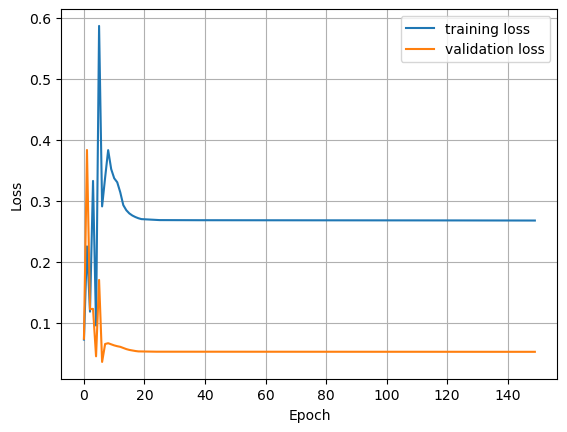

In [14]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Cheking 

In [15]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(color_im)
    depth_raw = o3d.geometry.Image(depth_im)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 1000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [16]:
inv_resize = transforms.Resize(480, interpolation=transforms.InterpolationMode.NEAREST)

In [18]:
# Model = AoRNet()
# Model.load_state_dict(torch.load('Modele/Small_RN_150Epoch'))
Model.eval()

AoRNet(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [19]:
# torch.manual_seed(101)
diff_X1 = []
diff_Y1 = []
diff_Z1 = []
diff_X2 = []
diff_Y2 = []
diff_Z2 = []

X1 = [] 
Y1 = [] 
Z1 = []
X2 = []
Y2 = []
Z2 = [] 

hX1 = [] 
hY1 = [] 
hZ1 = []
hX2 = []
hY2 = []
hZ2 = [] 

with torch.no_grad():
    for b, (X_validation, y_validation) in enumerate(validation_loader):
#         Apply the model
        
        X_validation = X_validation.to(device)
        y_validation = y_validation.to(device)
        

        y_val = Model(X_validation)
#         print(y_val.shape)
        for j in range(y_val.shape[0]):
            X_invNorm = inv_resize(X_validation[j])
            RGB_buff = X_invNorm[0].cpu().numpy()*255
#             RGB_buff = np.stack((X_invNorm[0].numpy(),X_invNorm[1].numpy(),X_invNorm[2].numpy()))*255
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = X_invNorm[1].cpu().numpy()*5500
            PC = CreatePointCloud(RGB_buff, DEPTH_buff)
            PREDICTED = [[y_val[j][0].cpu().numpy(), y_val[j][1].cpu().numpy(), y_val[j][2].cpu().numpy()],
                         [y_val[j][3].cpu().numpy(), y_val[j][4].cpu().numpy(), y_val[j][5].cpu().numpy()]]
            REAL = [[y_validation[j][0].cpu().numpy(), y_validation[j][1].cpu().numpy(), y_validation[j][2].cpu().numpy()],
                    [y_validation[j][3].cpu().numpy(), y_validation[j][4].cpu().numpy(), y_validation[j][5].cpu().numpy()]]
            draw_arrow(PC, REAL, PREDICTED)

            print(f'--> BATCH: {b+1} <-- | --> ROW: {j} <--')
            print(f'----------------------------------------------------------------------------------------------')
            print(f'{"X1":>12} {"Y1":>12} {"Z1":>12} {"X2":>12} {"Y2":>12} {"Z2":>12}')
            print(f'{"PREDICTED:"}')
            print(f'[[{y_val[j][0]:12.5f}, {y_val[j][1]:12.5f}, {y_val[j][2]:12.5f}], [{y_val[j][3]:12.5f}, {y_val[j][4]:12.5f}, {y_val[j][5]:12.5f}]]')
            print(f'{"REAL:"}')
            print(f'[[{y_validation[j][0]:12.5f}, {y_validation[j][1]:12.5f}, {y_validation[j][2]:12.5f}], [{y_validation[j][3]:12.5f}, {y_validation[j][4]:12.5f}, {y_validation[j][5]:12.5f}]]')
            print(f'{"DIFFERENCE:"}')
            diff = np.abs(y_val.cpu().numpy()-y_validation.cpu().numpy())
            print(f'[[{diff[j][0]:12.5f}, {diff[j][1]:12.5f}, {diff[j][2]:12.5f}], [{diff[j][3]:12.5f}, {diff[j][4]:12.5f}, {diff[j][5]:12.5f}]]')
            print(f'----------------------------------------------------------------------------------------------')
            diff_X1.append(diff[j][0])
            diff_Y1.append(diff[j][1])
            diff_Z1.append(diff[j][2])
            diff_X2.append(diff[j][3])
            diff_Y2.append(diff[j][4])
            diff_Z2.append(diff[j][5])
            
            X1.append(y_validation[j][0].cpu().numpy())
            Y1.append(y_validation[j][1].cpu().numpy())
            Z1.append(y_validation[j][2].cpu().numpy())
            X2.append(y_validation[j][3].cpu().numpy())
            Y2.append(y_validation[j][4].cpu().numpy())
            Z2.append(y_validation[j][5].cpu().numpy())

            hX1.append(y_val[j][0].cpu().numpy()) 
            hY1.append(y_val[j][1].cpu().numpy()) 
            hZ1.append(y_val[j][2].cpu().numpy())
            hX2.append(y_val[j][3].cpu().numpy())
            hY2.append(y_val[j][4].cpu().numpy())
            hZ2.append(y_val[j][5].cpu().numpy()) 
            

--> BATCH: 1 <-- | --> ROW: 0 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[    -0.02470,     -0.52178,      1.82812], [    -0.01255,      0.61857,      1.82059]]
REAL:
[[    -0.31443,     -0.78609,      2.03800], [    -0.27390,      0.83152,      2.06900]]
DIFFERENCE:
[[     0.28973,      0.26431,      0.20988], [     0.26134,      0.21295,      0.24841]]
----------------------------------------------------------------------------------------------
--> BATCH: 1 <-- | --> ROW: 1 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[    -0.01168,     -0.51944,      1.79414], [     0.00143,      0.59637,      1.79315]]
REAL:
[[    -0.10629,     -0.86348,      2.23850], [    -0.13628,      0.79469,      2.26800]]


--> BATCH: 2 <-- | --> ROW: 4 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[    -0.07574,     -0.60013,      1.88834], [    -0.07011,      0.61340,      1.91575]]
REAL:
[[    -0.02617,     -0.66037,      2.11400], [    -0.03380,      0.93092,      2.21650]]
DIFFERENCE:
[[     0.04956,      0.06024,      0.22566], [     0.03632,      0.31752,      0.30075]]
----------------------------------------------------------------------------------------------
--> BATCH: 2 <-- | --> ROW: 5 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[    -0.00523,     -0.50973,      1.78598], [    -0.00520,      0.59922,      1.79305]]
REAL:
[[     0.05654,     -0.47373,      1.85600], [     0.09394,      0.77630,      1.86100]]


In [20]:
# Save the model
torch.save(Model.state_dict(), 'Modele/Small_RN_150Epoch')

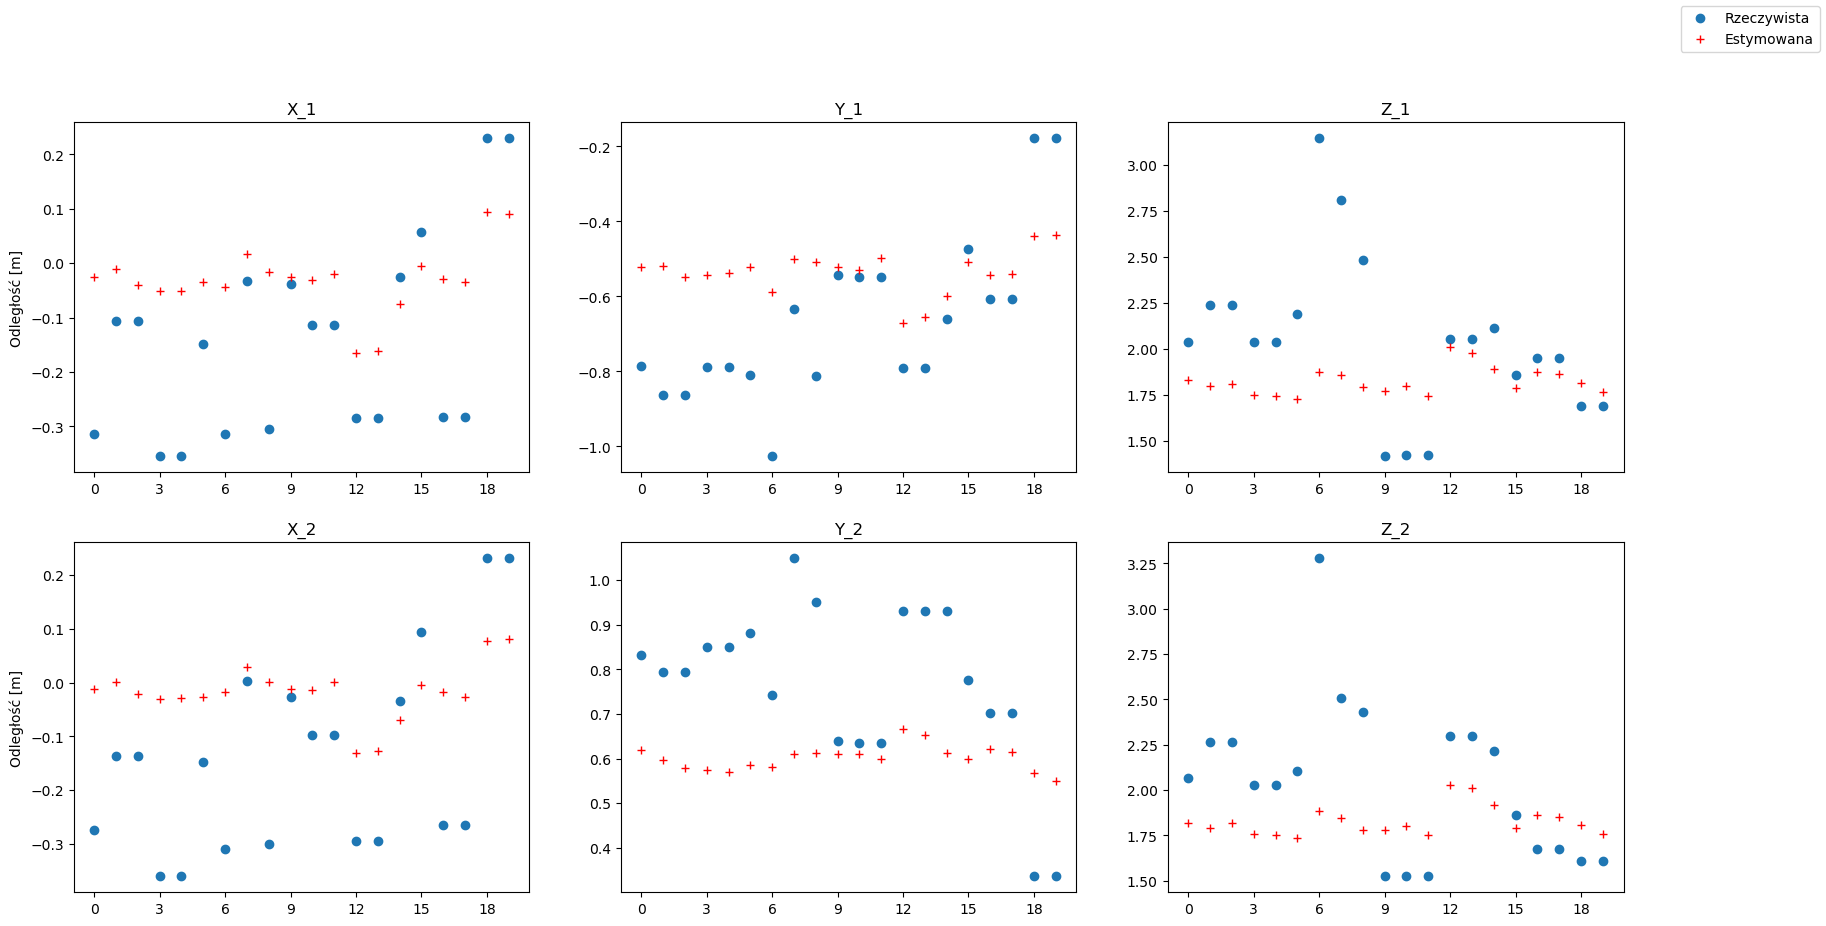

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(2, 3,figsize=(20,10))
axs[0, 0].plot(X1[0:20],'o')
axs[0, 0].plot(hX1[0:20],'+r')
axs[0, 0].set_title('X_1')
axs[0, 0].set(ylabel='Odległość [m]')

axs[0, 1].plot(Y1[0:20],'o')
axs[0, 1].plot(hY1[0:20],'+r')
axs[0, 1].set_title('Y_1')

axs[0, 2].plot(Z1[0:20],'o')
axs[0, 2].plot(hZ1[0:20],'+r')
axs[0, 2].set_title('Z_1')

axs[1, 0].plot(X2[0:20],'o')
axs[1, 0].plot(hX2[0:20],'+r')
axs[1, 0].set_title('X_2')
axs[1, 0].set(ylabel='Odległość [m]')

axs[1, 1].plot(Y2[0:20],'o')
axs[1, 1].plot(hY2[0:20],'+r')
axs[1, 1].set_title('Y_2')

axs[1, 2].plot(Z2[0:20],'o')
axs[1, 2].plot(hZ2[0:20],'+r')
axs[1, 2].set_title('Z_2')

for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# for ax in axs.flat:
#     ax.label_outer()

fig.legend(['Rzeczywista','Estymowana'])  


plt.show()
SAVE_DIR = '/home/el_zlociako/Documents/Praca_inzynierska/CNN/Ploty_do_inz/'
# fig.savefig(SAVE_DIR+'Small_REG_valid', format='eps')

In [22]:
X1_MEAN_DIFF = np.mean(diff_X1)
Y1_MEAN_DIFF = np.mean(diff_Y1)
Z1_MEAN_DIFF = np.mean(diff_Z1)
X2_MEAN_DIFF = np.mean(diff_X1)
Y2_MEAN_DIFF = np.mean(diff_Y2)
Z2_MEAN_DIFF = np.mean(diff_Z2)

MEAN_ERR = [X1_MEAN_DIFF, Y1_MEAN_DIFF, Z1_MEAN_DIFF, X2_MEAN_DIFF, Y2_MEAN_DIFF, Z2_MEAN_DIFF]
print(MEAN_ERR)

[0.15184437, 0.1829302, 0.3449678, 0.15184437, 0.22574794, 0.35150483]
